In [1]:
import sys
import os
sys.path.append('/home/jovyan/intake-aodn')
import intake_aodn
import intake
import fsspec
import xarray as xr

# Compare methods for chunked NetCDF file on the AODN

Note that only underlying chunks only one in time

## 1. XArray to thredds server

In [2]:
%%time
url = 'http://thredds.aodn.org.au/thredds/dodsC/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit.nc'
ds = xr.open_dataset(url,engine='netcdf4',decode_times=False,chunks='auto')
ds

CPU times: user 289 ms, sys: 12.5 ms, total: 301 ms
Wall time: 612 ms


<xarray.Dataset>
Dimensions:              (DAY_OF_YEAR: 365, LATITUDE: 4500, LONGITUDE: 6000)
Coordinates:
  * DAY_OF_YEAR          (DAY_OF_YEAR) int16 1 2 3 4 5 6 ... 361 362 363 364 365
  * LATITUDE             (LATITUDE) float32 -69.99 -69.97 -69.95 ... 19.97 19.99
  * LONGITUDE            (LONGITUDE) float32 70.01 70.03 70.05 ... 190.0 190.0
    DEPTH                float32 ...
Data variables:
    TEMP                 (DAY_OF_YEAR, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(73, 500, 750), meta=np.ndarray>
    TEMP_std_err         (DAY_OF_YEAR, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(73, 500, 750), meta=np.ndarray>
    TEMP_mean            (LATITUDE, LONGITUDE) float32 dask.array<chunksize=(4500, 6000), meta=np.ndarray>
    TEMP_mean_std_err    (LATITUDE, LONGITUDE) float32 dask.array<chunksize=(4500, 6000), meta=np.ndarray>
    TEMP_change          (LATITUDE, LONGITUDE) float32 dask.array<chunksize=(4500, 6000), meta=np.ndarray>
    TEMP_change_std_err  (LATITUDE, LONGITUDE) float32 dask.array<chunksize=(4500, 6000), meta=np.ndarray>
Attributes: (12/33)
    abstract:                      25 years of Advanced Very High-Resolution ...
    acknowledgement:               The User agrees that whenever the Product ...
    author:                        Galibert, Guillaume
    author_email:                  guillaume.galibert@utas.edu.au
    citation:                      The citation in a list of references is: "...
    Conventions:                   CF-1.6,IMOS-1.4
    ...                            ...
    source:                        One-day composites of night-only sea surfa...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2005-12-31T00:00:00Z
    time_coverage_start:           2005-01-01T00:00:00Z
    time_coverage_step:            1.0
    title:                         SST Atlas of Australian Regional Seas (SST...

In [3]:
%%time
ts=ds.TEMP.sel(LATITUDE=-32,LONGITUDE=115,method='nearest').load()

CPU times: user 16.1 ms, sys: 9 µs, total: 16.1 ms
Wall time: 5.68 s


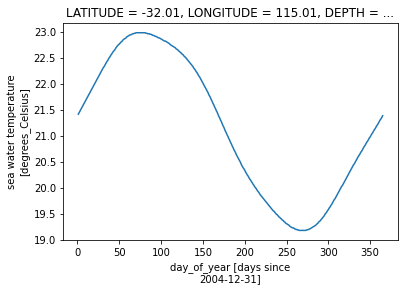

In [4]:
ts.plot()

## 2. XArray H5Netcdf engine to S3 Bucket|

In [5]:
%%time
url = 's3://imos-data/CSIRO/Climatology/SSTAARS/2017/AODN-product/SSTAARS_daily_fit.nc'
fo=fsspec.open(url,anon=True).open()
ds = xr.open_dataset(fo,engine='h5netcdf',decode_times=False,chunks='auto')
ds

CPU times: user 419 ms, sys: 177 ms, total: 597 ms
Wall time: 971 ms


<xarray.Dataset>
Dimensions:              (DAY_OF_YEAR: 365, LATITUDE: 4500, LONGITUDE: 6000)
Coordinates:
  * DAY_OF_YEAR          (DAY_OF_YEAR) int16 1 2 3 4 5 6 ... 361 362 363 364 365
  * LATITUDE             (LATITUDE) float32 -69.99 -69.97 -69.95 ... 19.97 19.99
  * LONGITUDE            (LONGITUDE) float32 70.01 70.03 70.05 ... 190.0 190.0
    DEPTH                float32 ...
Data variables:
    TEMP                 (DAY_OF_YEAR, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(73, 500, 750), meta=np.ndarray>
    TEMP_std_err         (DAY_OF_YEAR, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(73, 500, 750), meta=np.ndarray>
    TEMP_mean            (LATITUDE, LONGITUDE) float32 dask.array<chunksize=(4500, 6000), meta=np.ndarray>
    TEMP_mean_std_err    (LATITUDE, LONGITUDE) float32 dask.array<chunksize=(4500, 6000), meta=np.ndarray>
    TEMP_change          (LATITUDE, LONGITUDE) float32 dask.array<chunksize=(4500, 6000), meta=np.ndarray>
    TEMP_change_std_err  (LATITUDE, LONGITUDE) float32 dask.array<chunksize=(4500, 6000), meta=np.ndarray>
Attributes: (12/33)
    abstract:                      25 years of Advanced Very High-Resolution ...
    acknowledgement:               The User agrees that whenever the Product ...
    author:                        Galibert, Guillaume
    author_email:                  guillaume.galibert@utas.edu.au
    citation:                      The citation in a list of references is: "...
    Conventions:                   CF-1.6,IMOS-1.4
    ...                            ...
    source:                        One-day composites of night-only sea surfa...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2005-12-31T00:00:00Z
    time_coverage_start:           2005-01-01T00:00:00Z
    time_coverage_step:            [1.]
    title:                         SST Atlas of Australian Regional Seas (SST...

In [6]:
%%time
ts=ds.TEMP.sel(LATITUDE=-32,LONGITUDE=115,method='nearest').load()

CPU times: user 13.6 s, sys: 5.91 s, total: 19.5 s
Wall time: 36.5 s


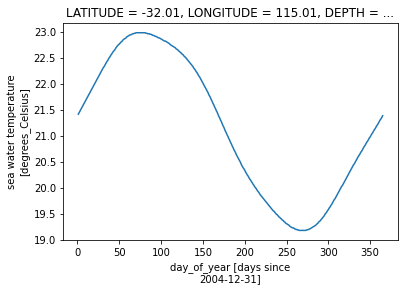

In [7]:
ts.plot()

## 3. Zarr references to netcdf (Cloud Native)

In [8]:
%%time
ds=intake_aodn.cat.aodn_s3.SSTAARS_Daily_Climatology(chunks='auto').to_dask()
ds

CPU times: user 352 ms, sys: 22.8 ms, total: 375 ms
Wall time: 547 ms


<xarray.Dataset>
Dimensions:              (DAY_OF_YEAR: 365, LATITUDE: 4500, LONGITUDE: 6000)
Coordinates:
  * DAY_OF_YEAR          (DAY_OF_YEAR) float32 1.0 2.0 3.0 ... 363.0 364.0 365.0
    DEPTH                float32 ...
  * LATITUDE             (LATITUDE) float32 -69.99 -69.97 -69.95 ... 19.97 19.99
  * LONGITUDE            (LONGITUDE) float32 70.01 70.03 70.05 ... 190.0 190.0
Data variables:
    TEMP                 (DAY_OF_YEAR, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(1, 900, 1200), meta=np.ndarray>
    TEMP_change          (LATITUDE, LONGITUDE) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    TEMP_change_std_err  (LATITUDE, LONGITUDE) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    TEMP_mean            (LATITUDE, LONGITUDE) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    TEMP_mean_std_err    (LATITUDE, LONGITUDE) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    TEMP_std_err         (DAY_OF_YEAR, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(1, 900, 1200), meta=np.ndarray>
Attributes: (12/33)
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      25 years of Advanced Very High-Resolution ...
    acknowledgement:               The User agrees that whenever the Product ...
    author:                        Galibert, Guillaume
    author_email:                  guillaume.galibert@utas.edu.au
    citation:                      The citation in a list of references is: "...
    ...                            ...
    source:                        One-day composites of night-only sea surfa...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2005-12-31T00:00:00Z
    time_coverage_start:           2005-01-01T00:00:00Z
    time_coverage_step:            1.0
    title:                         SST Atlas of Australian Regional Seas (SST...

In [9]:
%%time
ts=ds.TEMP.sel(LATITUDE=-32,LONGITUDE=115,method='nearest').load()

CPU times: user 6.57 s, sys: 346 ms, total: 6.92 s
Wall time: 3.95 s


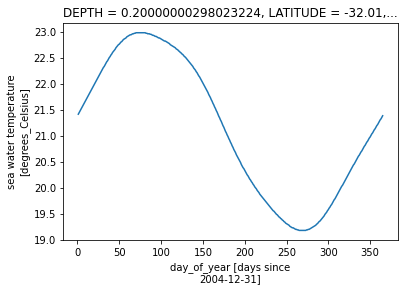

In [10]:
ts.plot()